<!-- https://www.kaggle.com/datasets/thevirusx3/automated-essay-scoring-dataset -->

Dataset Overview:
The dataset comprises several features that are crucial for understanding the nuances of essay writing and for building a model that can accurately score these essays. Here's a brief overview of the key components of the dataset:

Essay ID: A unique identifier for each essay. This is important for tracking and analyzing individual essays.

Essay Set: Indicates the set to which an essay belongs. The dataset contains essays from different sets, each potentially having different scoring criteria or topics.

Essay: The actual text of the essay. This is the most critical part of the dataset, as the NLP model will primarily analyze this text to score the essay.

Domain Prediction ID: A feature related to the first domain of prediction for the essay score.

Domain Score: This relates to the score of essay.

In [1]:
import os
import pandas as pd
import nltk
import numpy as np
import nltk

# nltk.download('stopwords')
# nltk.download('punkt')

C:\Users\aliyu\AppData\Local\Temp\ipykernel_15016\723087384.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATASET_DIR = './data'
SAVE_DIR = './'

# Load the dataset
data_set = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')

# Extract the column that contains the essay scores
score_col = data_set['domain1_score']

# Drop columns with missing values
data_set = data_set.dropna(axis=1)

# Drop specific columns that are not needed for the analysis
data_set = data_set.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [3]:
data_set.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


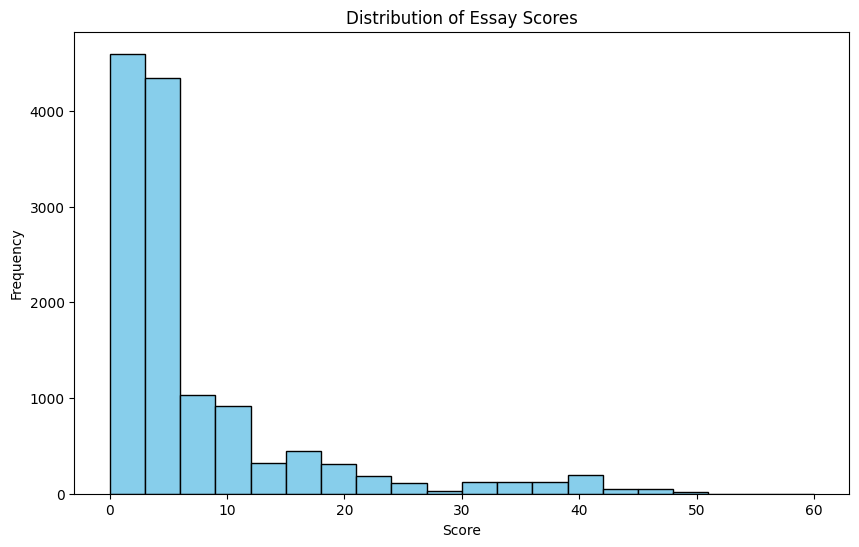

In [5]:
import matplotlib.pyplot as plt

# Plotting the distribution of essay scores
plt.figure(figsize=(10,6))
plt.hist(score_col, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [6]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

#  If your model predicts scores, it's important to normalize these predictions within the actual scoring range of the essays. For example, 
# if an essay set has scores ranging from 2 to 12, a predicted score of 13 would be invalid.
# Before training your model, you can use these ranges to validate the data. Any essay with a score outside these ranges can be considered an anomaly or an error. 

In [7]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words  # Removed the tuple to return a list.

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,), dtype="float32")
    num_words = 0.
    for word in words:
        if word in model.wv.key_to_index:  # Updated to use key_to_index.
            num_words += 1
            featureVec = np.add(featureVec, model.wv[word])  # Updated to use model.wv[word].
    if num_words == 0:
        return featureVec  # Return zeros if no valid words found.
    featureVec = np.divide(featureVec, num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    essayFeatureVecs = np.zeros((len(essays), num_features), dtype="float32")
    for i, essay in enumerate(essays):
        essayFeatureVecs[i] = makeFeatureVec(essay, model, num_features)
    return essayFeatureVecs


In [8]:
from keras.layers import LSTM, Dense, Dropout, Lambda
from keras.models import Sequential

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.


--------Fold 1--------

Training Word2Vec Model...


C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\692641134.py:40: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2


163/163 [==============================] - 5s 7ms/step - loss: 68.4653 - mae: 4.5020
Epoch 2/2
82/82 [==============================] - 1s

C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\692641134.py:40: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
163/163 [==============================] - 5s 7ms/step - loss: 65.3722 - mae: 4.3958
Epoch 2/2
82/82 [==============================] - 1s 2

C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\692641134.py:40: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_5 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
163/163 [==============================] - 5s 7ms/step - loss: 67.0112 - mae: 4.4724
Epoch 2/2
82/82 [==============================] - 1s 2

C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\692641134.py:40: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_7 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
163/163 [==============================] - 5s 7ms/step - loss: 67.7198 - mae: 4.4670
Epoch 2/2
82/82 [==============================] - 1s 2

C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\692641134.py:40: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_9 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
163/163 [==============================] - 5s 7ms/step - loss: 66.3843 - mae: 4.4499
Epoch 2/2
82/82 [==============================] - 1s 2

c:\Users\Adefemi\Desktop\eassay_score\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


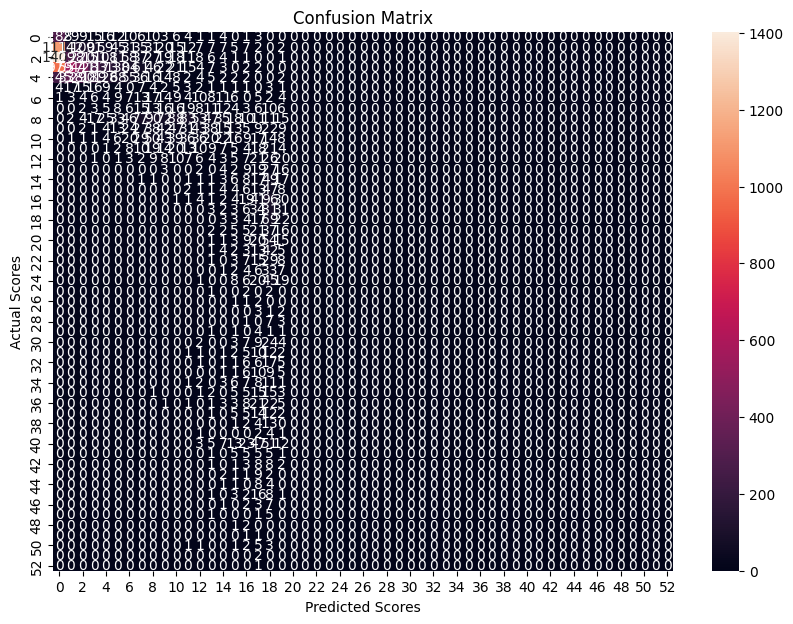

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []
all_y_pred = []
all_y_test = []

count = 1
for traincv, testcv in cv.split(data_set):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = data_set.iloc[testcv], data_set.iloc[traincv], score_col.iloc[testcv], score_col.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []

    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=2)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    y_pred = np.around(y_pred).flatten()  # Flatten and round predictions
    
    # Append predictions and actual scores to the lists
    all_y_pred.extend(y_pred)
    all_y_test.extend(y_test.values)
    
    # Save any one of the 5 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1
    
    


In [ ]:
# After completing all folds, create and plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


cm = confusion_matrix(all_y_test, all_y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Scores')
plt.xlabel('Predicted Scores')
plt.show()

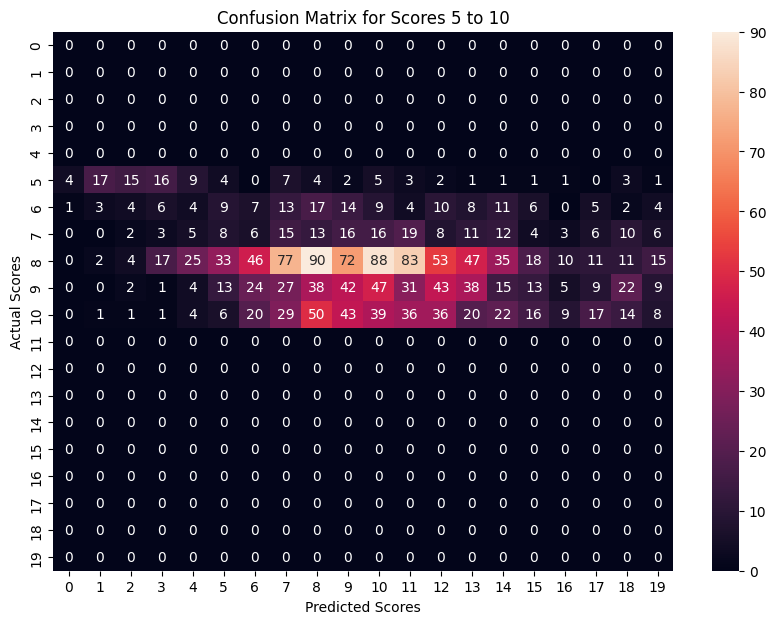

In [10]:
# Example: Focus on a specific range of scores, e.g., 5 to 10
subset_indices = [i for i in range(len(all_y_test)) if 5 <= all_y_test[i] <= 10]
subset_y_test = [all_y_test[i] for i in subset_indices]
subset_y_pred = [all_y_pred[i] for i in subset_indices]

cm_subset = confusion_matrix(subset_y_test, subset_y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_subset, annot=True, fmt="d")
plt.title('Confusion Matrix for Scores 5 to 10')
plt.ylabel('Actual Scores')
plt.xlabel('Predicted Scores')
plt.show()


Epoch 1/2
163/163 [==============================] - 2s 11ms/step - loss: 34.8257 - mae: 3.5439 - val_loss: 28.2031 - val_mae: 3.1723
Epoch 2/2
163/163 [==============================] - 1s 8ms/step - loss: 31.5989 - mae: 3.4541 - val_loss: 26.1345 - val_mae: 3.0577


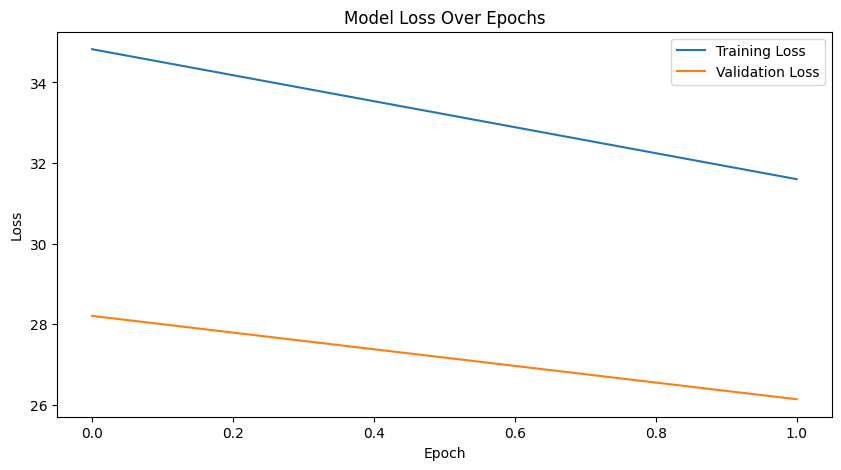

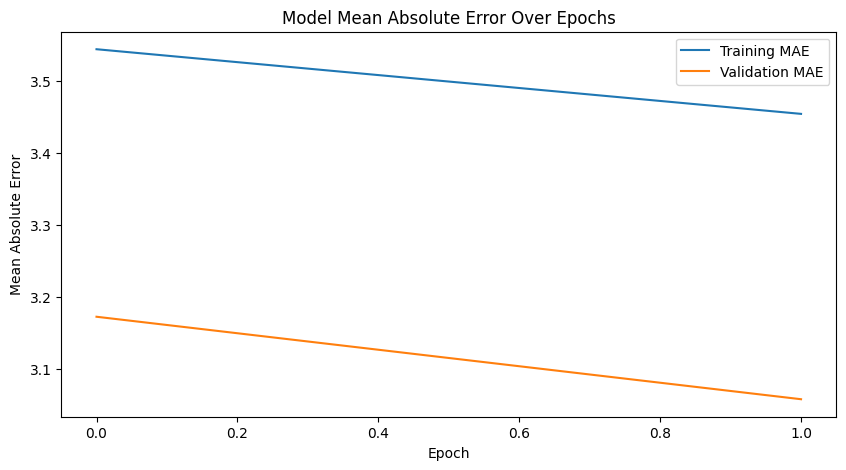

In [11]:
history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=2, validation_data=(testDataVecs, y_test))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training and validation MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')  # Replace 'mae' with 'mean_squared_error' if that's what you used
plt.plot(history.history['val_mae'], label='Validation MAE')  # Replace 'val_mae' with 'val_mean_squared_error' if necessary
plt.title('Model Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()


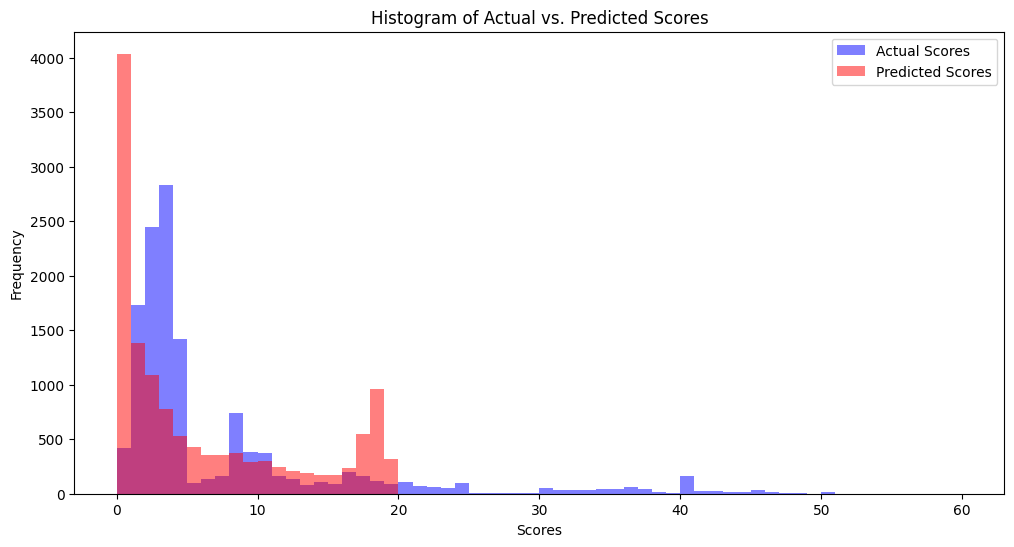

In [13]:
import matplotlib.pyplot as plt

# Convert predicted scores to integers
all_y_pred_int = [int(round(score)) for score in all_y_pred]

# Define the range for histogram bins
min_score = min(min(all_y_test), min(all_y_pred_int))
max_score = max(max(all_y_test), max(all_y_pred_int))
bins = range(min_score, max_score + 1)

plt.figure(figsize=(12, 6))

# Plotting histogram of actual scores
plt.hist(all_y_test, bins=bins, alpha=0.5, color='blue', label='Actual Scores')

# Plotting histogram of predicted scores
plt.hist(all_y_pred_int, bins=bins, alpha=0.5, color='red', label='Predicted Scores')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual vs. Predicted Scores')
plt.legend()
plt.show()


Rata-rata skor kappa is a statistical measure used to assess the level of agreement between two raters in evaluating a particular object or subject. Kappa scores range from -1 to 1, with a value of 1 indicating perfect agreement between the two raters, 0 indicating agreement that is the same as expected by chance, and -1 indicating perfect disagreement between the two raters 1. The average kappa score can be used to evaluate the reliability of an assessment instrument 1.

In [ ]:
print("Rata-rata skor kappa: ", np.around(np.array(results).mean(),decimals=4))

In [15]:
import math
from gensim.test.utils import datapath

essay_sample = """
        Dear @CAPS1 @CAPS2 I feel that computers do take away from peoples life and arent as important than the other factors of life. 
        First of all you know that the world is becoming obease because of lack of exercise. 
        Also people are becoming more and more anti-social because of computers.
    """

content = essay_sample

if len(content) > 20:
    num_features = 300
    clean_test_essays = []
    clean_test_essays.append(essay_to_wordlist(content, remove_stopwords=True))
    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)
    testDataVecs = np.array(testDataVecs)
    testDataVecs = np.reshape(
        testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1])
    )

    predict = lstm_model.predict(testDataVecs)

    if math.isnan(predict):
        predict = 0
    else:
        predict = np.round(predict)

    if predict < 0:
        predict = 0
else:
    predict = 0

print(predict)

1/1 [==============================] - 0s 25ms/step
[[2.]]


C:\Users\Adefemi\AppData\Local\Temp\ipykernel_6532\2328457022.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if math.isnan(predict):
